### Data Processing 

In [1]:
# using DataFrames, XLSX

# # Read the XLSX file into a DataFrame
# df = DataFrame(XLSX.readtable("pressure_tank.xlsx", "Sheet1"))

# #println(df)
# println(names(df))
# task_id = df[!, Symbol("Task ID")]
# task_name = df[!, Symbol("Task Name")]
# duration = df[!, Symbol("Duration")]
# predec = df[!, Symbol("Predecessors")]

# # Create an empty array to store the pairs
# pairs = Vector{Vector{Int64}}()

# # Iterate over each index
# for i in 1:length(task_id)
#     a = task_id[i]
#     b = predec[i]

#     # Skip if the element in B is missing
#     if b === missing
#         continue
#     end

#     # Check if the element in B is a string and needs splitting
#     if isa(b, String)
#         # Split the string by comma and convert to integers
#         split_b = parse.(Int, split(b, ","))
#         # Create pairs for each element in the split array
#         for sb in split_b
#             push!(pairs, [sb, a])

#         end
#     else
#         # If the element is not a string, pair it directly
#         push!(pairs, [b,a])
#     end
# end
# convert(Vector{Vector{Int64}}, pairs)

# # Print the result
# println(pairs)
# n = length(task_id)
# println(length(duration)==n, n)
# p = [[1, 5], [2,5], [3,5], [4,5]]
# println(typeof(pairs))

In [2]:
using DataFrames, XLSX

# Read the XLSX file into a DataFrame
df = DataFrame(XLSX.readtable("testing.xlsx", "Sheet1"))
1



1

### parsing 

In [3]:

#println(df)
println(names(df))
task_id = df[!, Symbol("Node Index")]
duration = df[!, Symbol("Processing Time")]
predec = df[!, Symbol("Predecessors")]

# Create an empty array to store the pairs
pairs = Vector{Vector{Int64}}()

# Iterate over each index
for i in 1:length(task_id)
    a = task_id[i]
    b = predec[i]

    # Skip if the element in B is missing
    if b === missing
        continue
    end

    # Check if the element in B is a string and needs splitting
    if isa(b, String)
        # Split the string by comma and convert to integers
        split_b = parse.(Int, split(b, ","))
        # Create pairs for each element in the split array
        for sb in split_b
            push!(pairs, [sb, a])

        end
    else
        # If the element is not a string, pair it directly
        push!(pairs, [b,a])
    end
end
convert(Vector{Vector{Int64}}, pairs)

# Print the result
println(pairs)
n = length(task_id)
println(length(duration)==n, n)
p = [[1, 5], [2,5], [3,5], [4,5]]
println(typeof(pairs))

["Node Index", "Level", "Processing Time", "Predecessors"]
[[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [5, 11], [3, 11], [7, 11], [9, 11], [4, 11], [6, 11], [8, 11], [10, 11], [4, 12], [3, 12], [7, 12], [2, 12], [5, 12], [11, 12], [6, 12], [10, 12], [9, 12], [10, 13], [2, 13], [6, 13], [3, 13], [4, 13], [3, 14], [7, 14], [12, 14], [9, 14], [6, 14], [13, 14], [8, 14], [5, 14], [3, 15], [14, 15], [9, 15], [13, 15], [4, 16], [5, 16], [13, 16], [10, 16], [11, 17], [8, 17], [7, 17], [9, 17], [4, 17], [13, 17], [2, 17], [3, 17], [4, 18], [17, 18], [4, 19], [3, 19], [10, 19], [7, 19], [14, 19], [4, 20], [12, 20], [3, 21], [18, 22], [9, 22], [5, 22], [16, 22], [17, 23], [5, 23], [16, 23], [19, 23], [11, 23], [19, 24], [22, 24], [3, 24], [23, 24], [4, 24], [16, 24], [5, 24], [12, 24], [13, 24], [6, 25], [11, 25], [7, 25], [10, 25], [5, 25], [20, 25], [19, 25], [24, 26], [17, 26], [22, 26], [9, 26], [18, 26], [7, 27], [15, 28], [13, 28], [2, 28], [14, 28], [19, 28],

### Gurobi Optimisation 

In [4]:
using JuMP
using Gurobi

#=
# Sample data
n = 10  # Number of operations
nf = 1  # Number of final assemblies
final_job = [5] # job number of final assembly, should correspond to nf
m = 2   # Number of machines
#f_k = [2, 3]  # Number of machines per work-center
M = 999
predefined_precedences = [[1, 5], [2,5], [3,5], [4,5]]  # Example list of predefined precedences
=#

n = n
nf = 1
final_job = [n]
m = 5
M = 999
predefined_precedences = pairs # see "data processing" section

# Due dates for final assemblies
D = [500]
# t = rand(1:5, n)  # Processing times (random example data)
t = duration
#bill of materials style

# Initialize model
model = Model(Gurobi.Optimizer)

# Variables
@variable(model, S[1:n] >= 0)
@variable(model, C[1:n] >= 0)
@variable(model, Ce[1:nf] >= 0)
@variable(model, δ[1:n, 1:n], Bin)
@variable(model, Δ[1:n, 1:m], Bin)
@variable(model, z >= 0)

# Objective
@objective(model, Max, z)

# Constraints

# initilising the job predcessors
for (j, i) in predefined_precedences
    @constraint(model, δ[i, j] == 1)
end

#alternative initilising
# for i in 1:n
#     for j in 1:n
#         if i != j
#             @constraint(model, S[j] >= C[i] - (1 - δ[i,j]) * M)
#         end
#     end
# end

#constraint 2.3
for i in 1:n
    @constraint(model, C[i] == S[i] + t[i])
    @constraint(model, z <= S[i])
end

# constraint 2.2
for (i, j) in predefined_precedences
    @constraint(model, S[j] >= C[i])
end

#constraint 2.4
for e in 1:nf
    @constraint(model, Ce[e] <= D[e])
    @constraint(model, Ce[e] == C[final_job[e]])
end

#constraint 2.5 # wed night updated (untested)
for i in 1:n, j in 1:n 
    if δ[i,j] == 1
        @constraint(model, δ[i,j] + δ[j,i] == 1)
    end
end


#constraint 2.6
for i in 1:n, j in 1:n, k in 1:m
    if i != j && i != k && j != k
        @constraint(model, S[i] - C[j] >= M * (δ[i, j] + Δ[i, k] + Δ[j, k] - 3))
    end
end

#constraint 2.7
for i in 1:n
    @constraint(model, sum(Δ[i, k] for k in 1:m) == 1)
end


Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-07


### model time

In [5]:
# Solve the model
optimize!(model)

# Get the results
println("Objective value (smallest start time): ", objective_value(model))
println("Start times: ", value.(S))
println("Completion times: ", value.(C))
println("Machine used: ", value.([k for i in 1:n, k in 1:m if value.(Δ[i, k]) == 1]))
println("Final assembly completion time(s): ", value.(Ce))

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 7735U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 12370 rows, 2852 columns and 59940 nonzeros
Model fingerprint: 0x19add435
Variable types: 102 continuous, 2750 integer (2750 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+03]
Presolve removed 12370 rows and 2852 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.02 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 382 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.820000000000e+02, best bound 3.820000000000e+02, gap 0.0000%

User-callback calls 585, time in user-callback 0.00 sec
Objectiv

### Gantt Chart

In [6]:
using Plots
using DataFrames

function generate_colors(num_shapes::Int) 
    predefined_colors = [:red, :green, :blue, :orange, :purple, :yellow, :brown, :pink, :gray, :black]
    return [predefined_colors[(i - 1) % length(predefined_colors) + 1] for i in 1:num_shapes]
end

rect(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])

function plot_rectangles(num_shapes::Int, labels::Vector{String}, start_times::Vector{Float64}, end_times::Vector{Float64})
    # Validate input lengths
    if length(labels) != num_shapes || length(start_times) != num_shapes || length(end_times) != num_shapes
        error("Length of labels, start_times, end_times must match num_shapes.")
    end
    colors = generate_colors(num_shapes)

    # Create DataFrame
    df = DataFrame(
        label = labels,
        start_time = start_times,
        end_time = end_times,
        color = colors
    )
    df.duration = df.end_time - df.start_time

    # Create rectangles
    r = [rect(t[1], 1, t[2], t[3]) for t in zip(df.duration, df.start_time, 1:nrow(df))]

    # Plot
    plot(r, c = df.color, yticks = (1.5:(nrow(df) + 0.5), df.label), xlabel = "Time", legend = false)
end
# Example data
# num_shapes = 4
# labels = ["Task 1", "Task 2", "Task 3", "4"]
# start_times = [1.0, 4.0, 7.0, 7.0]
# end_times = [3.0, 8.0, 9.0,9.0]

# Create the Gantt chart
# plot_rectangles(num_shapes, labels, start_times, end_times)


plot_rectangles (generic function with 1 method)

### Plot

┌ Warning: Column vector attribute `seriescolor` reinterpreted as row vector (one value per shape).
│ Pass a row vector instead (e.g. using `permutedims`) to suppress this warning.
└ @ Plots C:\Users\shian\.julia\packages\Plots\Pe7wF\src\recipes.jl:1372


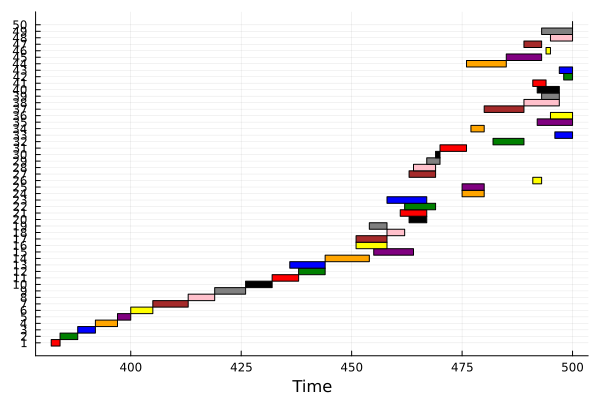

In [7]:
num_shapes= n
labels = [string(i) for i in 1:n]
#labels = [string(i) for i in task_name]
start_times= value.(S) #starts
end_times=value.(C) #ends

plot_rectangles(num_shapes, labels, start_times, end_times)

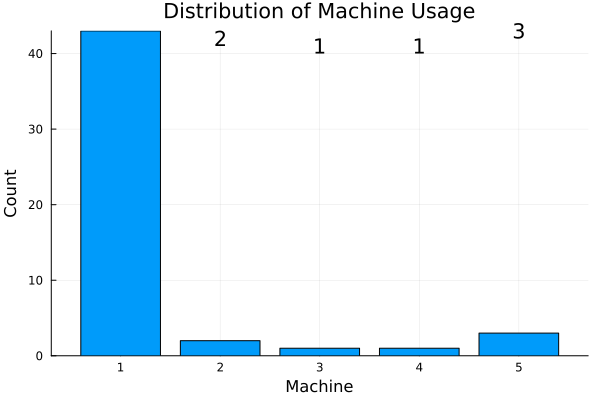

In [8]:
# Create the list based on the condition
my_list = [k for i in 1:n, k in 1:m if value.(Δ[i, k]) == 1]

# Count occurrences of each machine in the list
machine_counts = [count(x -> x == i, my_list) for i in 1:m]

# Plot the bar chart
bar_chart = bar(1:m, machine_counts, xlabel="Machine", ylabel="Count", title="Distribution of Machine Usage", legend=false)

# Add labels above each bar
for (i, count) in enumerate(machine_counts)
    annotate!(i, count + 40, string(count), ha=:center)
end
display(bar_chart)